# Rhythm Estimation and Evaluation of Bambucos

by:

Jose R. Zapata

**Project ACMUS:**  https://acmus-mir.github.io/


## Installing libraries

In [ ]:
import sys
import os
import pandas as pd
import numpy as np
import re
import time
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] =(12,6)

In [ ]:
!python -m pip install essentia -q
!python -m pip install madmom==0.15.0 -q  # Package for beat analysis that includes simple spectral flux calculation

     |████████████████████████████████| 11.7MB 331kB/s 
     |████████████████████████████████| 15.7MB 300kB/s 


In [ ]:
import madmom
import essentia.standard as es
import madmom.evaluation.beats as be # beat evaluation

In [ ]:
%load_ext google.colab.data_table

## Get Audiofiles

Audio Files and Annotation are in Zenodo:

https://zenodo.org/record/3965447/files/rhythm_set.zip?download=1

In [ ]:
#Download files from Zenodo
!wget -O rhythm_set.zip https://zenodo.org/record/3965447/files/rhythm_set.zip?download=1

--2020-07-29 19:26:13--  https://zenodo.org/record/3965447/files/rhythm_set.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1843834847 (1.7G) [application/octet-stream]
Saving to: ‘rhythm_set.zip’

rhythm_set.zip      100%[===================>]   1.72G  13.6MB/s    in 2m 24s  

2020-07-29 19:28:38 (12.2 MB/s) - ‘rhythm_set.zip’ saved [1843834847/1843834847]



In [ ]:
#Unzip file
!unzip -q rhythm_set.zip -d ./rhythm_set

## Get bambucos information

In [ ]:
audioDirectory = './rhythm_set/Audio/' # Audio files
anotationDirectory='./rhythm_set/Beat_annotations/' # Anotation files

In [ ]:
bambuco_set = pd.DataFrame(columns=['audiofile','simple_ann','compound_ann'])

In [ ]:
rhythm_set = pd.read_csv("./rhythm_set/rhythm_set.csv",sep = ';',encoding = "ISO-8859-1")

In [ ]:
bambuco_set['audiofile'] = rhythm_set[rhythm_set['Genre']=='bambuco']['File name'].str.strip()
bambuco_set.reset_index(drop=True, inplace = True)
print(f'Number of Bambuco Files = {len(bambuco_set)}')

Number of Bambuco Files = 73


In [ ]:
bambuco_set['simple_ann'] = bambuco_set['audiofile'].str.split('.').apply(lambda x: x[0])+'(0).txt'
bambuco_set['compound_ann'] = bambuco_set['audiofile'].str.split('.').apply(lambda x: x[0])+'(1).txt'


## Get Ground Truth

In [ ]:
def read_ann(file):
  '''
  function to read .txt annotations file
  returns numpy array
  '''
  beatsItt = list()
  
  with open(os.path.join(anotationDirectory, file), 'r') as f:
    lines= [line.split() for line in f]
    for line in lines:
      beatsItt.append(np.float32(line[0]))
    beatsItt=np.asarray(beatsItt)
    return beatsItt

In [ ]:
bambuco_set['simple_gt'] = bambuco_set['simple_ann'].apply(read_ann)
bambuco_set['compound_gt'] = bambuco_set['compound_ann'].apply(read_ann)

## Estimate Beats



### Madmom Beat Estimation

In [ ]:
# DownBeat = DB_
Rhythm_madmom = pd.DataFrame(columns=['File_name','Madmom_Beats'])

# Madmom
proc_beats = madmom.features.beats.BeatTrackingProcessor(fps=100)

for num, file in bambuco_set.iterrows():
  # Madmom Tempo estimation
  act = madmom.features.beats.RNNBeatProcessor()(audioDirectory+file['audiofile'])
  # Madmom Beat estimation
  beatsMadmom = np.float32(proc_beats(act))

  Rhythm_madmom.loc[len(Rhythm_madmom)] = [file['audiofile'], beatsMadmom]

### Essentia Beat estimation

In [ ]:
Rhythm_ess = pd.DataFrame(columns=['File_name', 'Essentia_Beats', 'Essentia_Bpm', 'Confidence'])
# Essentia
rhythm_extractor = es.RhythmExtractor2013(method="multifeature")

for num, file in bambuco_set.iterrows():
  rhythm_extractor = es.RhythmExtractor2013(method="multifeature")
    
  # Essentia estimations 
  audio = es.MonoLoader(filename=audioDirectory+file['audiofile'])()
  try:
    bpmEss,beatsEss, beats_confidence, _, _ = rhythm_extractor(audio)
  except:
    bpmEss = 0
    beatsEss = 0
    beats_confidence = 0
  Rhythm_ess.loc[len(Rhythm_ess)] = [file['audiofile'], beatsEss, bpmEss, beats_confidence]
  del audio

# Beat Evaluation


## Simple Meter


### Madmom Evaluation


In [ ]:
# Create a column by evaluation metrics
Rhythm_madmom['fmeasure']=''
Rhythm_madmom['amlc']=''
Rhythm_madmom['amlt']=''
Rhythm_madmom['cmlc']=''
Rhythm_madmom['cmlt']=''
Rhythm_madmom['Eval'] =''

In [ ]:
for n, file in bambuco_set.iterrows():
  Rhythm_madmom['Eval'][n] = be.BeatEvaluation(Rhythm_madmom['Madmom_Beats'][n], file['simple_gt'])
  Rhythm_madmom['fmeasure'][n]= Rhythm_madmom['Eval'][n].fmeasure*100
  Rhythm_madmom['amlc'][n]= Rhythm_madmom['Eval'][n].amlc*100
  Rhythm_madmom['amlt'][n]= Rhythm_madmom['Eval'][n].amlt*100
  Rhythm_madmom['cmlc'][n]= Rhythm_madmom['Eval'][n].cmlc*100
  Rhythm_madmom['cmlt'][n]= Rhythm_madmom['Eval'][n].cmlt*100

/usr/local/lib/python3.6/dist-packages/madmom/evaluation/beats.py:948: UserWarning: Not enough beat annotations (30) for 40 histogram bins.
  % (len(annotations), num_bins))
/usr/local/lib/python3.6/dist-packages/madmom/evaluation/beats.py:948: UserWarning: Not enough beat annotations (31) for 40 histogram bins.
  % (len(annotations), num_bins))
/usr/local/lib/python3.6/dist-packages/madmom/evaluation/beats.py:948: UserWarning: Not enough beat annotations (23) for 40 histogram bins.
  % (len(annotations), num_bins))
/usr/local/lib/python3.6/dist-packages/madmom/evaluation/beats.py:948: UserWarning: Not enough beat annotations (28) for 40 histogram bins.
  % (len(annotations), num_bins))
/usr/local/lib/python3.6/dist-packages/madmom/evaluation/beats.py:948: UserWarning: Not enough beat annotations (25) for 40 histogram bins.
  % (len(annotations), num_bins))
/usr/local/lib/python3.6/dist-packages/madmom/evaluation/beats.py:948: UserWarning: Not enough beat annotations (34) for 40 histog

In [ ]:
Rhythm_madmom[['fmeasure','amlc', 'amlt', 'cmlc', 'cmlt']] = Rhythm_madmom[['fmeasure', 'amlc', 'amlt', 'cmlc', 'cmlt']].apply(pd.to_numeric)

#### Results


In [ ]:
colu = ['fmeasure', 'amlc', 'amlt', 'cmlc', 'cmlt']
Rhythm_madmom[colu].describe()

,fmeasure,amlc,amlt,cmlc,cmlt
count,73.000000,73.000000,73.000000,73.000000,73.000000
mean,75.058638,60.758798,77.048379,50.886777,64.269013
std,31.586736,30.280944,27.250458,36.318821,37.949375
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,59.523810,35.593220,75.862069,20.312500,30.434783
50%,91.525424,62.790698,88.888889,45.833333,83.333333
75%,97.500000,91.666667,94.444444,89.285714,93.750000
max,100.000000,100.000000,100.000000,100.000000,100.000000


In [ ]:
pd.DataFrame(Rhythm_madmom[colu].mean()).T

,fmeasure,amlc,amlt,cmlc,cmlt
0,75.058638,60.758798,77.048379,50.886777,64.269013


#### Boxplot


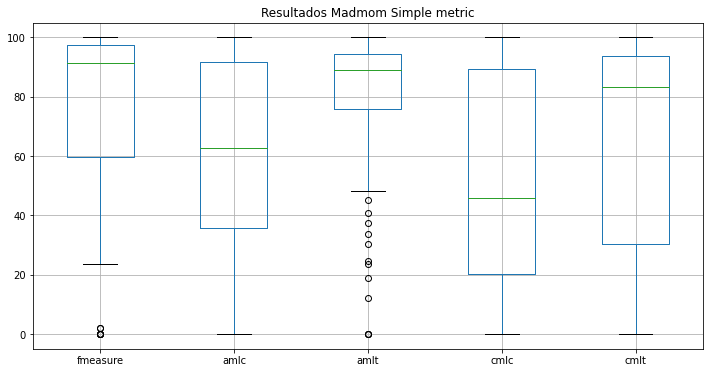

In [ ]:
plt.rcParams["figure.figsize"] =(12,6) 
Rhythm_madmom[colu].boxplot()
plt.title('Resultados Madmom Simple metric');

### Essentia Evaluation

In [ ]:
# Create a column by evaluation metrics
Rhythm_ess['fmeasure']=''
Rhythm_ess['amlc']=''
Rhythm_ess['amlt']=''
Rhythm_ess['cmlc']=''
Rhythm_ess['cmlt']=''
Rhythm_ess['Eval'] =''

In [ ]:
for n, file in bambuco_set.iterrows():  
  Rhythm_ess['Eval'][n] = be.BeatEvaluation(Rhythm_ess['Essentia_Beats'][n], file['simple_gt'])
  Rhythm_ess['fmeasure'][n]= Rhythm_ess['Eval'][n].fmeasure*100
  Rhythm_ess['amlc'][n]= Rhythm_ess['Eval'][n].amlc*100
  Rhythm_ess['amlt'][n]= Rhythm_ess['Eval'][n].amlt*100
  Rhythm_ess['cmlc'][n]= Rhythm_ess['Eval'][n].cmlc*100
  Rhythm_ess['cmlt'][n]= Rhythm_ess['Eval'][n].cmlt*100

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from 

In [ ]:
Rhythm_ess[colu] = Rhythm_ess[colu].apply(pd.to_numeric)

#### Results


In [ ]:
Rhythm_ess[colu].describe()

,fmeasure,amlc,amlt,cmlc,cmlt
count,73.000000,73.000000,73.000000,73.000000,73.000000
mean,42.791785,23.323934,25.241873,12.429100,14.333930
std,20.885613,35.740289,37.622162,27.600007,30.655093
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.897436,0.000000,0.000000,0.000000,0.000000
50%,38.461538,3.030303,3.225806,0.000000,0.000000
75%,40.963855,42.857143,44.230769,2.083333,2.083333
max,99.115044,100.000000,100.000000,98.245614,98.245614


In [ ]:
pd.DataFrame(Rhythm_ess[colu].mean()).T

,fmeasure,amlc,amlt,cmlc,cmlt
0,42.791785,23.323934,25.241873,12.4291,14.33393


#### Boxplot


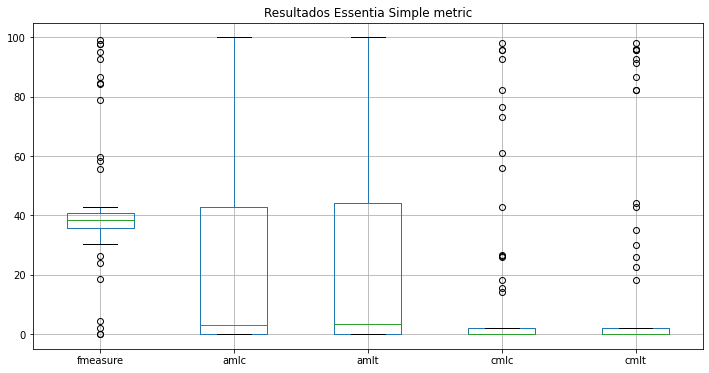

In [ ]:
plt.rcParams["figure.figsize"] =(12,6) 
Rhythm_ess[colu].boxplot()
plt.title('Resultados Essentia Simple metric');

## Compound Meter

### Madmom Evaluation


In [ ]:
# Create a column by evaluation metrics
Rhythm_madmom['fmeasure_comp']=''
Rhythm_madmom['amlc_comp']=''
Rhythm_madmom['amlt_comp']=''
Rhythm_madmom['cmlc_comp']=''
Rhythm_madmom['cmlt_comp']=''
Rhythm_madmom['Eval_comp'] =''

In [ ]:
for n, file in bambuco_set.iterrows():  
  Rhythm_madmom['Eval_comp'][n] = be.BeatEvaluation(Rhythm_madmom['Madmom_Beats'][n], file['compound_gt'])
  Rhythm_madmom['fmeasure_comp'][n]= Rhythm_madmom['Eval_comp'][n].fmeasure*100
  Rhythm_madmom['amlc_comp'][n]= Rhythm_madmom['Eval_comp'][n].amlc*100
  Rhythm_madmom['amlt_comp'][n]= Rhythm_madmom['Eval_comp'][n].amlt*100
  Rhythm_madmom['cmlc_comp'][n]= Rhythm_madmom['Eval_comp'][n].cmlc*100
  Rhythm_madmom['cmlt_comp'][n]= Rhythm_madmom['Eval_comp'][n].cmlt*100

/usr/local/lib/python3.6/dist-packages/madmom/evaluation/beats.py:948: UserWarning: Not enough beat annotations (38) for 40 histogram bins.
  % (len(annotations), num_bins))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [ ]:
colu2 = ['fmeasure_comp', 'amlc_comp', 'amlt_comp', 'cmlc_comp', 'cmlt_comp']
Rhythm_madmom[colu2] = Rhythm_madmom[colu2].apply(pd.to_numeric)

#### Results


In [ ]:
Rhythm_madmom[colu2].describe()

,fmeasure_comp,amlc_comp,amlt_comp,cmlc_comp,cmlt_comp
count,73.000000,73.000000,73.000000,73.000000,73.000000
mean,41.127235,9.233116,10.706591,5.639417,5.719667
std,14.593595,22.233321,23.923117,19.459426,19.453500
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,36.363636,0.000000,0.000000,0.000000,0.000000
50%,39.175258,0.884956,0.917431,0.000000,0.000000
75%,40.506329,3.448276,5.555556,0.000000,0.000000
max,100.000000,100.000000,100.000000,100.000000,100.000000


In [ ]:
pd.DataFrame(Rhythm_madmom[colu2].mean()).T

,fmeasure_comp,amlc_comp,amlt_comp,cmlc_comp,cmlt_comp
0,41.127235,9.233116,10.706591,5.639417,5.719667


#### Boxplot


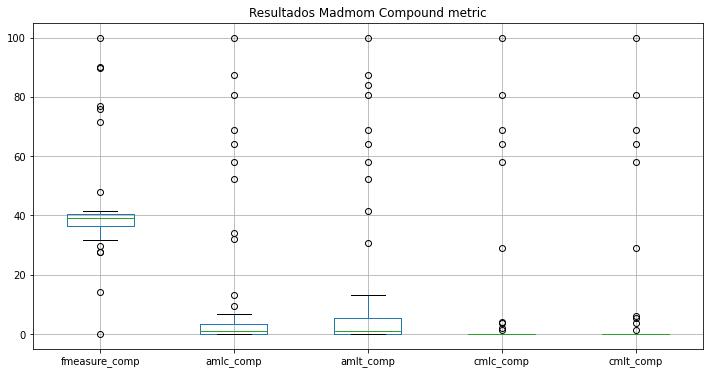

In [ ]:
plt.rcParams["figure.figsize"] =(12,6) 
Rhythm_madmom[colu2].boxplot()
plt.title('Resultados Madmom Compound metric');

### Essentia Evaluation

In [ ]:
# Create a column by evaluation metrics
Rhythm_ess['fmeasure_comp']=''
Rhythm_ess['amlc_comp']=''
Rhythm_ess['amlt_comp']=''
Rhythm_ess['cmlc_comp']=''
Rhythm_ess['cmlt_comp']=''
Rhythm_ess['Eval_comp'] =''

In [ ]:
for n, file in bambuco_set.iterrows():  
  Rhythm_ess['Eval_comp'][n] = be.BeatEvaluation(Rhythm_ess['Essentia_Beats'][n], file['compound_gt'])
  Rhythm_ess['fmeasure_comp'][n]= Rhythm_ess['Eval_comp'][n].fmeasure*100
  Rhythm_ess['amlc_comp'][n]= Rhythm_ess['Eval_comp'][n].amlc*100
  Rhythm_ess['amlt_comp'][n]= Rhythm_ess['Eval_comp'][n].amlt*100
  Rhythm_ess['cmlc_comp'][n]= Rhythm_ess['Eval_comp'][n].cmlc*100
  Rhythm_ess['cmlt_comp'][n]= Rhythm_ess['Eval_comp'][n].cmlt*100

/usr/local/lib/python3.6/dist-packages/madmom/evaluation/beats.py:948: UserWarning: Not enough beat annotations (38) for 40 histogram bins.
  % (len(annotations), num_bins))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [ ]:
Rhythm_ess[colu2] = Rhythm_ess[colu2].apply(pd.to_numeric)

#### Results


In [ ]:
Rhythm_ess[colu2].describe()

,fmeasure_comp,amlc_comp,amlt_comp,cmlc_comp,cmlt_comp
count,73.000000,73.000000,73.000000,73.000000,73.000000
mean,45.150686,42.871665,51.762088,32.381748,35.535146
std,36.449156,37.740108,39.336583,40.477310,43.224106
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.500000,4.878049,6.060606,0.000000,0.000000
50%,38.297872,33.333333,50.000000,3.846154,3.846154
75%,88.888889,86.666667,94.444444,71.875000,93.750000
max,100.000000,100.000000,100.000000,100.000000,100.000000


In [ ]:
pd.DataFrame(Rhythm_ess[colu2].mean()).T

,fmeasure_comp,amlc_comp,amlt_comp,cmlc_comp,cmlt_comp
0,45.150686,42.871665,51.762088,32.381748,35.535146


#### Boxplot


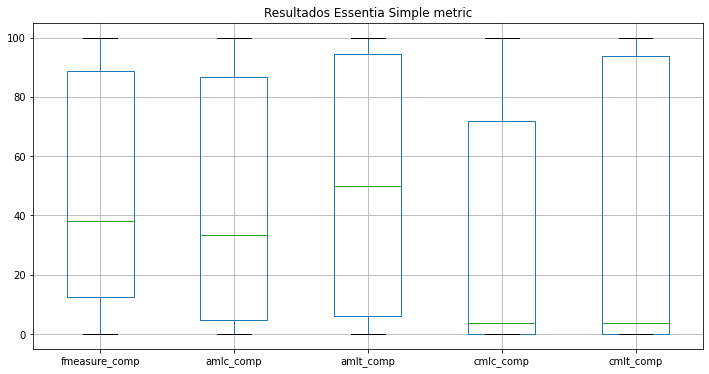

In [ ]:
plt.rcParams["figure.figsize"] =(12,6) 
Rhythm_ess[colu2].boxplot()
plt.title('Resultados Essentia Simple metric');

# General Results

In [ ]:
simple = pd.concat([Rhythm_madmom[colu].mean(), Rhythm_ess[colu].mean()], axis=1).T
simple['names'] =['Madmom', 'Essentia']
simple.set_index('names',inplace=True)
print('Simple Meter results')
simple.round(2)

Simple Meter results


,fmeasure,amlc,amlt,cmlc,cmlt
names,,,,,
Madmom,75.06,60.76,77.05,50.89,64.27
Essentia,42.79,23.32,25.24,12.43,14.33


In [ ]:
compound = pd.concat([Rhythm_madmom[colu2].mean(), Rhythm_ess[colu2].mean()], axis=1).T
compound['names'] =['Madmom', 'Essentia']
compound.set_index('names',inplace=True)
print('Compound Meter Results')
compound.round(2)

Compound Meter Results


,fmeasure_comp,amlc_comp,amlt_comp,cmlc_comp,cmlt_comp
names,,,,,
Madmom,41.13,9.23,10.71,5.64,5.72
Essentia,45.15,42.87,51.76,32.38,35.54
